<a href="https://colab.research.google.com/github/georgezoto/TensorFlow-in-Practice/blob/master/C4W2_3_Time_series_TSN_Multi_Dense_learning_rate_mse.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

<a href="https://colab.research.google.com/github/lmoroney/dlaicourse/blob/master/TensorFlow%20In%20Practice/Course%204%20-%20S%2BP/S%2BP%20Week%202%20Lesson%203.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass


In [0]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
print(tf.__version__)

2.2.0-rc3


In [0]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

def trend(time, slope=0):
    return slope * time

def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

time = np.arange(4 * 365 + 1, dtype="float32")
baseline = 10
series = trend(time, 0.1)  
baseline = 10
amplitude = 20
slope = 0.09
noise_level = 5

# Create the series
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)
# Update with noise
series += noise(time, noise_level, seed=42)

split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

my_epochs = 100

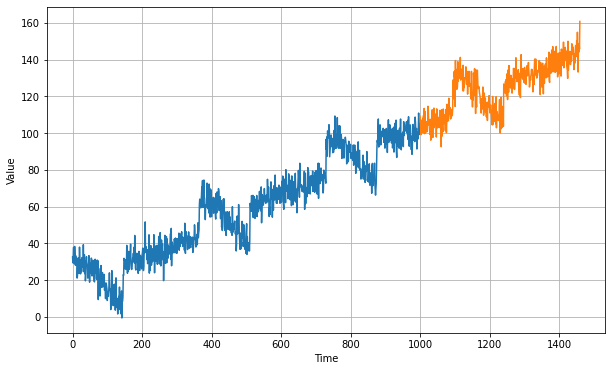

In [0]:
plt.figure(figsize=(10, 6))
plot_series(time_train, x_train)
plot_series(time_valid, x_valid)

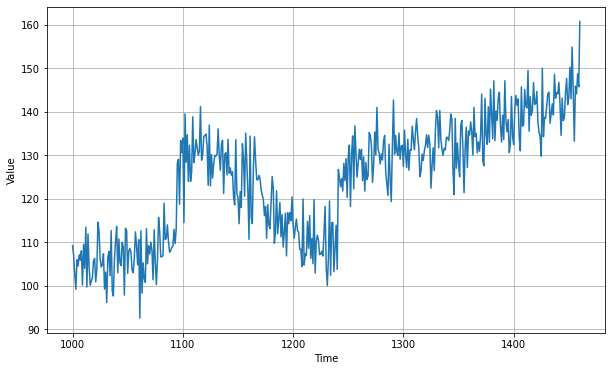

In [0]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)

In [0]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
  dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
  dataset = dataset.batch(batch_size).prefetch(1)
  return dataset

In [0]:
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)


model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(10, input_shape=[window_size], activation="relu"), 
    tf.keras.layers.Dense(10, activation="relu"), 
    tf.keras.layers.Dense(1)
])

model.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(lr=1e-6, momentum=0.9))
model.fit(dataset,epochs=my_epochs,verbose=1)

Epoch 1/100
31/31 [==============================] - 0s 3ms/step - loss: 1091.4923
Epoch 2/100
31/31 [==============================] - 0s 3ms/step - loss: 73.1662
Epoch 3/100
31/31 [==============================] - 0s 2ms/step - loss: 57.1098
Epoch 4/100
31/31 [==============================] - 0s 2ms/step - loss: 57.2422
Epoch 5/100
31/31 [==============================] - 0s 3ms/step - loss: 56.1123
Epoch 6/100
31/31 [==============================] - 0s 3ms/step - loss: 55.9700
Epoch 7/100
31/31 [==============================] - 0s 2ms/step - loss: 54.7356
Epoch 8/100
31/31 [==============================] - 0s 2ms/step - loss: 53.8672
Epoch 9/100
31/31 [==============================] - 0s 3ms/step - loss: 52.6522
Epoch 10/100
31/31 [==============================] - 0s 2ms/step - loss: 52.8755
Epoch 11/100
31/31 [==============================] - 0s 3ms/step - loss: 52.4371
Epoch 12/100
31/31 [==============================] - 0s 3ms/step - loss: 51.4281
Epoch 13/100
31/31 [===

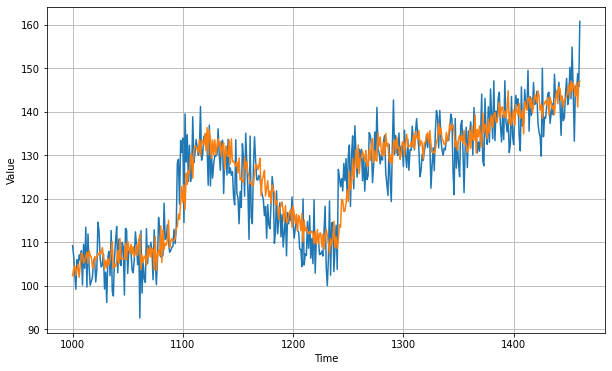

In [0]:
forecast = []
for time in range(len(series) - window_size):
  forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]


plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [0]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

4.678847

In [0]:
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(10, input_shape=[window_size], activation="relu"), 
    tf.keras.layers.Dense(10, activation="relu"), 
    tf.keras.layers.Dense(1)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-8 * 10**(epoch / 20))

optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss="mse", optimizer=optimizer)

history = model.fit(dataset, epochs=my_epochs, callbacks=[lr_schedule], verbose=1)

Epoch 1/100
31/31 [==============================] - 0s 2ms/step - loss: 1920.7651 - lr: 1.0000e-08
Epoch 2/100
31/31 [==============================] - 0s 2ms/step - loss: 523.0129 - lr: 1.1220e-08
Epoch 3/100
31/31 [==============================] - 0s 3ms/step - loss: 111.8844 - lr: 1.2589e-08
Epoch 4/100
31/31 [==============================] - 0s 3ms/step - loss: 52.8962 - lr: 1.4125e-08
Epoch 5/100
31/31 [==============================] - 0s 3ms/step - loss: 48.9459 - lr: 1.5849e-08
Epoch 6/100
31/31 [==============================] - 0s 3ms/step - loss: 48.5832 - lr: 1.7783e-08
Epoch 7/100
31/31 [==============================] - 0s 3ms/step - loss: 48.5631 - lr: 1.9953e-08
Epoch 8/100
31/31 [==============================] - 0s 2ms/step - loss: 48.6182 - lr: 2.2387e-08
Epoch 9/100
31/31 [==============================] - 0s 2ms/step - loss: 48.2855 - lr: 2.5119e-08
Epoch 10/100
31/31 [==============================] - 0s 2ms/step - loss: 48.1762 - lr: 2.8184e-08
Epoch 11/100
31

(1e-08, 0.001, 0.0, 300.0)

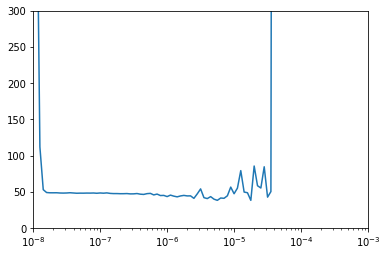

In [0]:
lrs = 1e-8 * (10 ** (np.arange(my_epochs) / 20))
plt.semilogx(lrs, history.history["loss"])
plt.axis([1e-8, 1e-3, 0, 300])

In [0]:
window_size = 30
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Dense(10, activation="relu", input_shape=[window_size]),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1)
])

optimizer = tf.keras.optimizers.SGD(lr=8e-6, momentum=0.9)
model.compile(loss="mse", optimizer=optimizer)
history = model.fit(dataset, epochs=my_epochs, verbose=0)

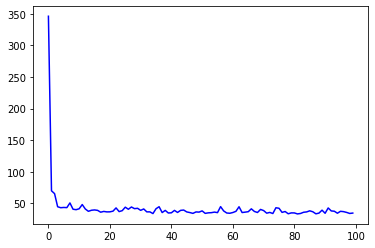

In [0]:
loss = history.history['loss']
epochs = range(len(loss))
plt.plot(epochs, loss, 'b', label='Training Loss')
plt.show()

[41.522789001464844, 48.20726776123047, 41.1973762512207, 37.524784088134766, 39.18979263305664, 39.69864273071289, 39.016929626464844, 36.11281967163086, 37.324031829833984, 36.597782135009766, 36.68252944946289, 37.75041961669922, 42.87678909301758, 37.08386993408203, 38.520111083984375, 44.05119705200195, 40.76268005371094, 44.34740447998047, 41.7427864074707, 42.283390045166016, 39.039493560791016, 41.23656463623047, 36.63142776489258, 36.64162826538086, 33.94273376464844, 41.582122802734375, 44.774749755859375, 35.53964614868164, 38.97280502319336, 34.83692932128906, 35.15935134887695, 38.96747589111328, 35.729705810546875, 39.00547409057617, 39.51937484741211, 36.538978576660156, 35.541160583496094, 34.252628326416016, 36.53654098510742, 36.25920486450195, 38.19004821777344, 34.265899658203125, 35.09003448486328, 35.36133575439453, 36.25587844848633, 35.44580078125, 44.92973709106445, 38.116905212402344, 34.83939743041992, 34.42914581298828, 35.60752868652344, 37.50736999511719, 

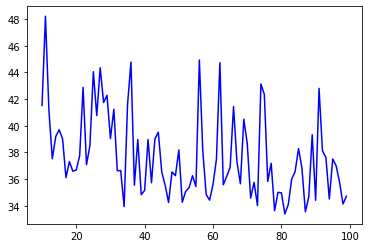

In [0]:
# Plot all but the first 10
loss = history.history['loss']
epochs = range(10, len(loss))
plot_loss = loss[10:]
print(plot_loss)
plt.plot(epochs, plot_loss, 'b', label='Training Loss')
plt.show()

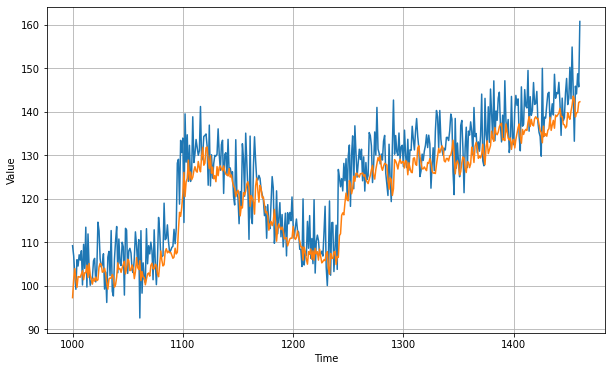

In [0]:
forecast = []
for time in range(len(series) - window_size):
  forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]


plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [0]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

5.301772